# FloPy

### SWI2 Example 4. Upconing Below a Pumping Well in a Two-Aquifer Island System

This example problem is the fourth example problem in the SWI2 documentation (http://pubs.usgs.gov/tm/6a46/) and simulates transient movement of the freshwater-seawater interface beneath an island in response to recharge and groundwater withdrawals. The island is 2,050$\times$2,050 m and consists of two 20-m thick aquifers that extend below sea level. The aquifers are confined, storage changes are not considered (all MODFLOW stress periods are steady-state), and the top and bottom of each aquifer is horizontal. The top of the upper aquifer and the bottom of the lower aquifer are impermeable.

The domain is discretized into 61 columns, 61 rows, and 2 layers, with respective cell dimensions of 50 m (`DELR`), 50 m (`DELC`), and 20 m. A total of 230 years is simulated using three stress periods with lengths of 200, 12, and 18 years, with constant time steps of 0.2, 0.1, and 0.1 years, respectively. 

The horizontal and vertical hydraulic conductivity of both aquifers are 10 m/d and 0.2 m/d, respectively. The effective porosity is 0.2 for both aquifers. The model is extended 500 m offshore along all sides and the ocean boundary is represented as a general head boundary condition (GHB) in model layer 1. A freshwater head of 0 m is specified at the ocean bottom in all general head boundaries. The GHB conductance that controls outflow from the aquifer into the ocean is 62.5 m$^{2}$/d and corresponds to a leakance of 0.025 d$^{-1}$ (or a resistance of 40 days).

The groundwater is divided into a freshwater zone and a seawater zone, separated by an active ZETA surface between the zones (`NSRF=1`) that approximates the 50-percent seawater salinity contour. Fluid density is represented using the stratified density option (`ISTRAT=1`). The dimensionless density difference ($\nu$) between freshwater and saltwater is 0.025. The tip and toe tracking parameters are a `TOESLOPE` and `TIPSLOPE` of 0.005, a default `ALPHA` of 0.1, and a default `BETA` of 0.1. Initially, the interface between freshwater and saltwater is 1 m below land surface on the island and at the top of the upper aquifer offshore. The SWI2 `ISOURCE` parameter is set to -2 in cells having GHBs so that water that infiltrates into the aquifer from the GHB cells is saltwater (zone 2), whereas water that flows out of the model at the GHB cells is identical to water at the top of the aquifer. `ISOURCE` in layer 2, row 31, column 36 is set to 2 so that a saltwater well may be simulated in the third stress period of simulation 2. In all other cells, the SWI2 `ISOURCE` parameter is set to 0, indicating boundary conditions have water that is identical to water at the top of the aquifer and can be either freshwater or saltwater, depending on the elevation of the active `ZETA` surface in the cell.

A constant recharge rate of 0.4 millimeters per day (mm/d) is used in all three stress periods. The development of the freshwater lens is simulated for 200 years, after which a pumping well having a withdrawal rate of 250 m$^3$/d is started in layer 1, row 31, column 36. For the first simulation (simulation 1), the well pumps for 30 years, after which the interface almost reaches the top of the upper aquifer layer. In the second simulation (simulation 2), an additional well withdrawing
saltwater at a rate of 25 m$^3$/d is simulated below the freshwater well in layer 2 , row 31, column 36, 12 years after the freshwater groundwater withdrawal begins in the well in layer 1. The saltwater well is intended to prevent the interface from
upconing into the upper aquifer (model layer).

Import `numpy` and `matplotlib`, set all figures to be inline, import `flopy.modflow` and `flopy.utils`.

In [1]:
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy
3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.14.5
matplotlib version: 2.2.2
flopy version: 3.2.11


Define model name of your model and the location of MODFLOW executable. All MODFLOW files and output will be stored in the subdirectory defined by the workspace. Create a model named `ml` and specify that this is a MODFLOW-2005 model.

In [2]:
#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('data')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

Define the number of layers, rows and columns. The heads are computed quasi-steady state (hence a steady MODFLOW run) while the interface will move. There are three stress periods with a length of 200, 12, and 18 years and 1,000, 120, and 180 steps. 

In [3]:
ncol = 61
nrow = 61
nlay = 2

nper = 3
perlen = [365.25 * 200., 365.25 * 12., 365.25 * 18.]
nstp = [1000, 120, 180]
save_head = [200, 60, 60]
steady = True

Specify the cell size along the rows (`delr`) and along the columns (`delc`) and the top and bottom of the aquifer for the `DIS` package. 

In [4]:
# dis data
delr, delc = 50.0, 50.0
botm = np.array([-10., -30., -50.])

Define the `IBOUND` array and starting heads for the `BAS` package. The corners of the model are defined to be inactive.

In [5]:
# bas data
# ibound - active except for the corners
ibound = np.ones((nlay, nrow, ncol), dtype= np.int)
ibound[:, 0, 0] = 0
ibound[:, 0, -1] = 0
ibound[:, -1, 0] = 0
ibound[:, -1, -1] = 0
# initial head data
ihead = np.zeros((nlay, nrow, ncol), dtype=np.float)

Define the layers to be confined and define the horizontal and vertical hydraulic conductivity of the aquifer for the `LPF` package.

In [6]:
# lpf data
laytyp = 0
hk = 10.
vka = 0.2

Define the boundary condition data for the model

In [7]:
# boundary condition data
# ghb data
colcell, rowcell = np.meshgrid(np.arange(0, ncol), np.arange(0, nrow))
index = np.zeros((nrow, ncol), dtype=np.int)
index[:, :10] = 1
index[:, -10:] = 1
index[:10, :] = 1
index[-10:, :] = 1
nghb = np.sum(index)
lrchc = np.zeros((nghb, 5))
lrchc[:, 0] = 0
lrchc[:, 1] = rowcell[index == 1]
lrchc[:, 2] = colcell[index == 1]
lrchc[:, 3] = 0.
lrchc[:, 4] = 50.0 * 50.0 / 40.0
# create ghb dictionary
ghb_data = {0:lrchc}

# recharge data
rch = np.zeros((nrow, ncol), dtype=np.float)
rch[index == 0] = 0.0004
# create recharge dictionary
rch_data = {0: rch}

# well data
nwells = 2
lrcq = np.zeros((nwells, 4))
lrcq[0, :] = np.array((0, 30, 35, 0))
lrcq[1, :] = np.array([1, 30, 35, 0])
lrcqw = lrcq.copy()
lrcqw[0, 3] = -250
lrcqsw = lrcq.copy()
lrcqsw[0, 3] = -250.
lrcqsw[1, 3] = -25.
# create well dictionary
base_well_data = {0:lrcq, 1:lrcqw}
swwells_well_data = {0:lrcq, 1:lrcqw, 2:lrcqsw}

In [8]:
# swi2 data
nadptmx = 10
nadptmn = 1
nu = [0, 0.025]
numult = 5.0
toeslope = nu[1] / numult  #0.005
tipslope = nu[1] / numult  #0.005
z1 = -10.0 * np.ones((nrow, ncol))
z1[index == 0] = -11.0
z = np.array([[z1, z1]])
iso = np.zeros((nlay, nrow, ncol), dtype=np.int)
iso[0, :, :][index == 0] = 1
iso[0, :, :][index == 1] = -2
iso[1, 30, 35] = 2
ssz=0.2
# swi2 observations
obsnam = ['layer1_', 'layer2_']
obslrc=[[0, 30, 35], [1, 30, 35]]
nobs = len(obsnam)
iswiobs = 1051

Create output control (OC) data using words 

In [9]:
# oc data
spd = {(0,199): ['print budget', 'save head'],
       (0,200): [],
       (0,399): ['print budget', 'save head'],
       (0,400): [],
       (0,599): ['print budget', 'save head'],
       (0,600): [],
       (0,799): ['print budget', 'save head'],
       (0,800): [],
       (0,999): ['print budget', 'save head'],
       (1,0): [],
       (1,59): ['print budget', 'save head'],
       (1,60): [],
       (1,119): ['print budget', 'save head'],
       (1,120): [],
       (2,0): [],
       (2,59): ['print budget', 'save head'],
       (2,60): [],
       (2,119): ['print budget', 'save head'],
       (2,120): [],
       (2,179): ['print budget', 'save head']}

Create the model with the freshwater well (Simulation 1)

In [10]:
modelname = 'swiex4_s1'
ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=botm[0], botm=botm[1:],
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=ihead)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=hk, vka=vka)
wel = flopy.modflow.ModflowWel(ml, stress_period_data=base_well_data)
ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
swi = flopy.modflow.ModflowSwi2(ml, nsrf=1, istrat=1, toeslope=toeslope, tipslope=tipslope, nu=nu,
                                zeta=z, ssz=ssz, isource=iso, nsolver=1,
                                nadptmx=nadptmx, nadptmn=nadptmn, 
                                nobs=nobs, iswiobs=iswiobs, obsnam=obsnam, obslrc=obslrc, iswizt=55)
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)

ModflowSwi2: specification of nobs is deprecated.


Write the simulation 1 MODFLOW input files and run the model

In [11]:
ml.write_input()
ml.run_model(silent=True)

(True, [])

Create the model with the saltwater well (Simulation 2)

In [12]:
modelname2 = 'swiex4_s2'
ml2 = flopy.modflow.Modflow(modelname2, version='mf2005', exe_name=exe_name, model_ws=workspace)

discret = flopy.modflow.ModflowDis(ml2, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=botm[0], botm=botm[1:],
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml2, ibound=ibound, strt=ihead)
lpf = flopy.modflow.ModflowLpf(ml2, laytyp=laytyp, hk=hk, vka=vka)
wel = flopy.modflow.ModflowWel(ml2, stress_period_data=swwells_well_data)
ghb = flopy.modflow.ModflowGhb(ml2, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml2, rech=rch_data)
swi = flopy.modflow.ModflowSwi2(ml2, nsrf=1, istrat=1, 
                                toeslope=toeslope, tipslope=tipslope, nu=nu,
                                zeta=z, ssz=ssz, isource=iso, nsolver=1,
                                nadptmx=nadptmx, nadptmn=nadptmn,
                                nobs=nobs, iswiobs=iswiobs, obsnam=obsnam, obslrc=obslrc, iswizt=55)
oc = flopy.modflow.ModflowOc(ml2, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml2, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)

ModflowSwi2: specification of nobs is deprecated.


Write the simulation 2 MODFLOW input files and run the model

In [13]:
ml2.write_input()
ml2.run_model(silent=True)

(True, [])

Load the simulation 1 `ZETA` data and `ZETA` observations.

In [14]:
# read base model zeta
zfile = flopy.utils.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))
kstpkper = zfile.get_kstpkper()
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])
zeta = np.array(zeta)
# read swi obs
zobs = np.genfromtxt(os.path.join(ml.model_ws, modelname+'.zobs.out'), names=True)

Load the simulation 2 `ZETA` data and `ZETA` observations.

In [15]:
# read saltwater well model zeta
zfile2 = flopy.utils.CellBudgetFile(os.path.join(ml2.model_ws, modelname2+'.zta'))
kstpkper = zfile2.get_kstpkper()
zeta2 = []
for kk in kstpkper:
    zeta2.append(zfile2.get_data(kstpkper=kk, text='ZETASRF  1')[0])
zeta2 = np.array(zeta2)
# read swi obs
zobs2 = np.genfromtxt(os.path.join(ml2.model_ws, modelname2+'.zobs.out'), names=True)

Create arrays for the x-coordinates and the output years

In [16]:
x = np.linspace(-1500, 1500, 61)
xcell = np.linspace(-1500, 1500, 61) + delr / 2.
xedge = np.linspace(-1525, 1525, 62)
years = [40, 80, 120, 160, 200, 6, 12, 18, 24, 30]

Define figure dimensions and colors used for plotting `ZETA` surfaces

In [17]:
# figure dimensions
fwid, fhgt = 8.00, 5.50
flft, frgt, fbot, ftop = 0.125, 0.95, 0.125, 0.925

# line color definition
icolor = 5
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

Recreate **Figure 9** from the SWI2 documentation (http://pubs.usgs.gov/tm/6a46/).

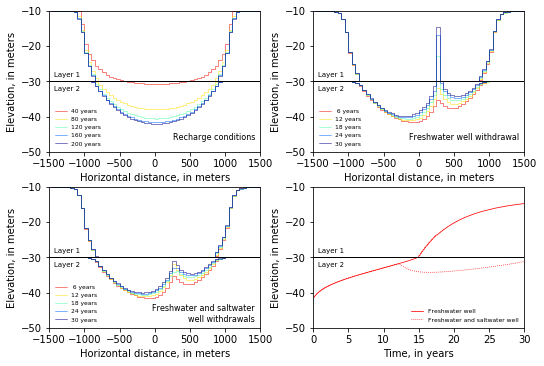

In [18]:
plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
fig = plt.figure(figsize=(fwid, fhgt), facecolor='w')
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)
# first plot
ax = fig.add_subplot(2, 2, 1)
# axes limits
ax.set_xlim(-1500, 1500)
ax.set_ylim(-50, -10)
for idx in range(5):
    # layer 1
    ax.plot(xcell, zeta[idx, 0, 30, :], drawstyle='steps-mid', 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
    # layer 2
    ax.plot(xcell, zeta[idx, 1, 30, :], drawstyle='steps-mid',
            linewidth=0.5, color=cc[idx], label='_None')
ax.plot([-1500, 1500], [-30, -30], color='k', linewidth=1.0)
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance, in meters')
ax.set_ylabel('Elevation, in meters')
ax.text(0.025, .55, 'Layer 1', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.025, .45, 'Layer 2', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.975, .1, 'Recharge conditions', transform=ax.transAxes, va='center', ha='right', size='8')

# second plot
ax = fig.add_subplot(2, 2, 2)
# axes limits
ax.set_xlim(-1500, 1500)
ax.set_ylim(-50, -10)
for idx in range(5, len(years)):
    # layer 1
    ax.plot(xcell, zeta[idx, 0, 30, :], drawstyle='steps-mid', 
            linewidth=0.5, color=cc[idx-5], label='{:2d} years'.format(years[idx]))
    # layer 2
    ax.plot(xcell, zeta[idx, 1, 30, :], drawstyle='steps-mid',
            linewidth=0.5, color=cc[idx-5], label='_None')
ax.plot([-1500, 1500], [-30, -30], color='k', linewidth=1.0)
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance, in meters')
ax.set_ylabel('Elevation, in meters')
ax.text(0.025, .55, 'Layer 1', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.025, .45, 'Layer 2', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.975, .1, 'Freshwater well withdrawal', transform=ax.transAxes, va='center', ha='right', size='8')

# third plot
ax = fig.add_subplot(2, 2, 3)
# axes limits
ax.set_xlim(-1500, 1500)
ax.set_ylim(-50, -10)
for idx in range(5, len(years)):
    # layer 1
    ax.plot(xcell, zeta2[idx, 0, 30, :], drawstyle='steps-mid', 
            linewidth=0.5, color=cc[idx-5], label='{:2d} years'.format(years[idx]))
    # layer 2
    ax.plot(xcell, zeta2[idx, 1, 30, :], drawstyle='steps-mid',
            linewidth=0.5, color=cc[idx-5], label='_None')
ax.plot([-1500, 1500], [-30, -30], color='k', linewidth=1.0)
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance, in meters')
ax.set_ylabel('Elevation, in meters')
ax.text(0.025, .55, 'Layer 1', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.025, .45, 'Layer 2', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.975, .1, 'Freshwater and saltwater\nwell withdrawals', transform=ax.transAxes,
        va='center', ha='right', size='8')

# fourth plot
ax = fig.add_subplot(2, 2, 4)
# axes limits
ax.set_xlim(0, 30)
ax.set_ylim(-50, -10)
t = zobs['TOTIM'][999:] / 365 - 200.
tz2 = zobs['layer1_001'][999:]
tz3 = zobs2['layer1_001'][999:]
for i in range(len(t)):
    if zobs['layer2_001'][i+999] < -30. - 0.1:
        tz2[i] = zobs['layer2_001'][i+999]
    if zobs2['layer2_001'][i+999] < 20. - 0.1:
        tz3[i] = zobs2['layer2_001'][i+999]
ax.plot(t, tz2, linestyle='solid', color='r', linewidth=0.75, label='Freshwater well')
ax.plot(t, tz3, linestyle='dotted', color='r', linewidth=0.75, label='Freshwater and saltwater well')
ax.plot([0, 30], [-30, -30], 'k', linewidth=1.0, label='_None')
# legend
leg = plt.legend(loc='lower right', numpoints=1)
# axes labels and text
ax.set_xlabel('Time, in years')
ax.set_ylabel('Elevation, in meters')
ax.text(0.025, .55, 'Layer 1', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.025, .45, 'Layer 2', transform=ax.transAxes, va='center', ha='left', size='7');

Use `ModelCrossSection` plotting class and `plot_fill_between()` method to fill between zeta surfaces.

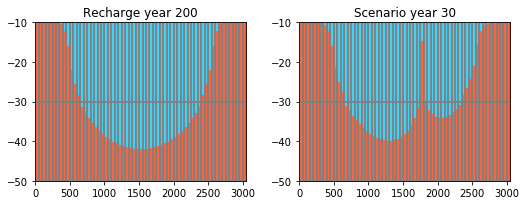

In [19]:
fig = plt.figure(figsize=(fwid, fhgt/2))
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)

colors = ['#40d3f7', '#F76541']

ax = fig.add_subplot(1, 2, 1)
modelxsect = flopy.plot.PlotCrossSection(model=ml, line={'Row': 30}, 
                                         extent=(0, 3050, -50, -10))
modelxsect.plot_fill_between(zeta[4, :, :, :], colors=colors, ax=ax,
                              edgecolors='none')
linecollection = modelxsect.plot_grid(ax=ax)
ax.set_title('Recharge year {}'.format(years[4]));

ax = fig.add_subplot(1, 2, 2)
ax.set_xlim(0, 3050)
ax.set_ylim(-50, -10)
modelxsect.plot_fill_between(zeta[-1, :, :, :], colors=colors, ax=ax)
linecollection = modelxsect.plot_grid(ax=ax)
ax.set_title('Scenario year {}'.format(years[-1]));